### Converting Mathematica Pathfinder dice code into Python - 20200524 CJH
---
* Much of this is plotting wizardry to get histograms and multiple lineplots to tell the story properly
* Under the hood the joint distributions are really fast if you use some tricks to use multiple smaller lists (that I figured out empirically, should ask stack exchange)
    * Need to check speed vs mathematica    
* Basic math is as follows:
    * itertools.product is used for the tuples
    * `list(map(sum, all_tuples))` to get it ready to feed to numpy with np.array(sums)
    * to get the unique tuples and the probabilities use `unique, counts = np.unique(array_sums, return_counts=True)`
* I learned how to use `**kwargs` for the first time here to pass keyword dictionaries into `hitstats` and other derived functions

#### TODO:
* System for labeling (location in plots, making it prettier)
* Chart improvement in general (font, bar widths, text locations, maybe cumulative probablilty)
* Object oriented approach: set of kwargs gets the whole treatment, then a class function that starts the calcs and stores the images/dfs
* Monte Carlo of the attack list - double check and fun

### How to use
#### the functions make_histogram, multiple_attack, ac_scan and ac_scan_comparison in diceroll all take lists of the following:
#### kwargs = {'hit_bonus':15, 'AC':20, 'nd_list':[(2,6), (1,4)], 'bonus':4, 'dice_type':'normal'}

In [1]:
import itertools as it
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

In [2]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import matplotlib as mpl
mpl.style.use('seaborn') #default, seaborn

In [3]:
import diceroll as dice

In [4]:
from importlib import reload

In [5]:
def rr():
    reload(dice)

In [6]:
n=2
d=8
bonus = 0

### Demonstrate hit and crit probabilities 

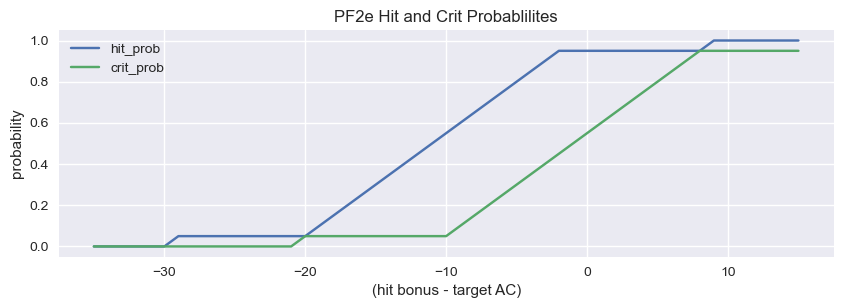

In [7]:
rr()
AC = 0
results = []
for hit_bonus in range(-35, 15+1, 1):
    message_h, hit_probability = dice.to_hit(hit_bonus,AC)
    message_c, crit_probability = dice.to_crit(hit_bonus,AC)
    results.append([hit_bonus, hit_probability, crit_probability])
    #print(f'ATT {hit_bonus:3d} vs AC {AC}: Max: {(hit_bonus+20)-AC:3d} Min: {(hit_bonus+1)-AC:3d} Hit: {message_h:18s} Prob: {hit_probability:.2f} Crit: {message_c:20s} Prob: {crit_probability:.2f}  ')
    df= pd.DataFrame(results, columns=['hit_bonus','hit_prob','crit_prob'])
    
plt.figure(num=None, figsize=(10,3),dpi=100)
plt.grid(True)
plt.plot('hit_bonus', 'hit_prob',data=df)
plt.plot('hit_bonus', 'crit_prob',data=df)
plt.legend(['hit_prob','crit_prob'], loc='upper left')
plt.title(f'PF2e Hit and Crit Probablilites')
plt.xlabel('(hit bonus - target AC)')
plt.ylabel('probability')
plt.show()


### Demonstrate dice.pmdf() (probablilty mass density functions)

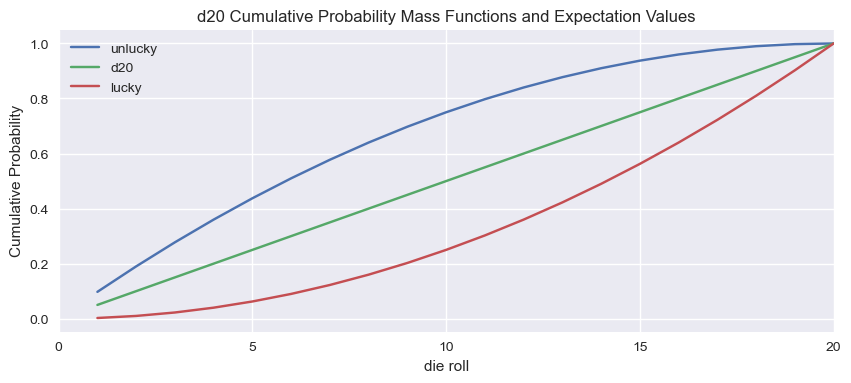

In [8]:
die = 20
dist = np.zeros((20,4))
dist[:,0] = np.arange(1,21)
dist[:,1] = np.cumsum(dice.pmdf(die, dice_type='normal')[:,1])
dist[:,2]= np.cumsum(dice.pmdf(die, dice_type='lucky')[:,1])
dist[:,3] = np.cumsum(dice.pmdf(die, dice_type='unlucky')[:,1])

expect_lucky = np.dot(list(range(1,21)),(dice.pmdf(die, dice_type='lucky')[:,1]))
expect_unlucky = np.dot(list(range(1,21)),(dice.pmdf(die, dice_type='unlucky')[:,1]))
expect_normal = np.dot(list(range(1,21)),(dice.pmdf(die, dice_type='normal')[:,1]))

df= pd.DataFrame(dist, columns=['roll','d20','lucky','unlucky'])
fig = plt.figure(num=None, figsize=(10,4),dpi=100)

ax = plt.subplot(111)  # trick to create axes to mess with 
ax.set_xlim(0,20)
ax.set_xticks([tick for tick in ax.get_xticks() if tick % 1 == 0])  # found this trick to get rid of non-integer ticks
plt.plot('roll', 'unlucky', data=df)
plt.plot('roll', 'd20', data=df)
plt.plot('roll', 'lucky', data=df) #color = 'xkcd:green'
plt.plot(expect_lucky,0.5,'x',color='C2') 
plt.plot(expect_normal,0.5,'x', color='C1')
plt.plot(expect_unlucky,0.5,'x', color='C0') 

plt.legend(['unlucky', 'd20','lucky'], loc='upper left')
plt.title('d20 Cumulative Probability Mass Functions and Expectation Values')
plt.xlabel('die roll')
plt.ylabel('Cumulative Probability')
#plt.fill_between(df['roll'], 0, df['lucky'], facecolor='#2ca02c')
plt.show()

### Making labels with dice.make_label()

In [9]:
rr()
kwargs = {'hit_bonus':10, 'AC':20, 'nd_list':[(2,8)], 'bonus':4, 'dice_type':'normal'}
kwargs_test = {'hit_bonus':15, 'AC':20, 'nd_list':[(2,6),(1,4)], 'bonus':4, 'dice_type':'normal'}
dice.make_label([kwargs_test,kwargs,kwargs,kwargs])

'+15 vs 20AC @ 2d6+1d4+4, +10 vs 20AC @ 2d8+4, +10 vs 20AC @ 2d8+4, +10 vs 20AC @ 2d8+4'

### Using dice.hitstats() to generate a single damage distribution

In [10]:
dice.hitstats(hit_bonus=15, AC=20, nd_list=[(1,4)], bonus=4, dice_type='normal')

array([[ 0.   ,  0.2  ],
       [ 5.   ,  0.125],
       [ 6.   ,  0.125],
       [ 7.   ,  0.125],
       [ 8.   ,  0.125],
       [10.   ,  0.075],
       [12.   ,  0.075],
       [14.   ,  0.075],
       [16.   ,  0.075]])

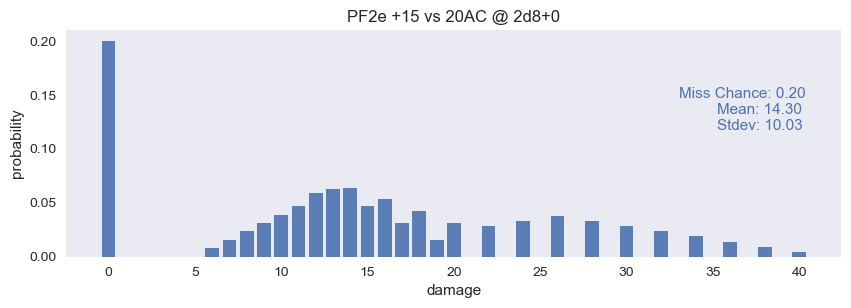

In [11]:
rr()
pdist=dice.hitstats(hit_bonus=15, AC=20, nd_list=[(2,8)], bonus=4, dice_type='normal')
dice.make_histogram([pdist], title='PF2e +15 vs 20AC @ 2d8+0')

### Breaking up rolls to get large distributions in only a few seconds with dice.dice_list()

Unchunked time guesstimate is 5000000000.00 s
Unchunked guesstimate 5000000000.00s exceeds time limit of 10s...
Splitting in chunks of 6 to save processing time...
create tuples       :   0.50   Delta:   0.00
it products         :  19.93   Delta:  19.44
sums & prods        : 208.12   Delta: 188.18
groupby             : 261.52   Delta:  53.40


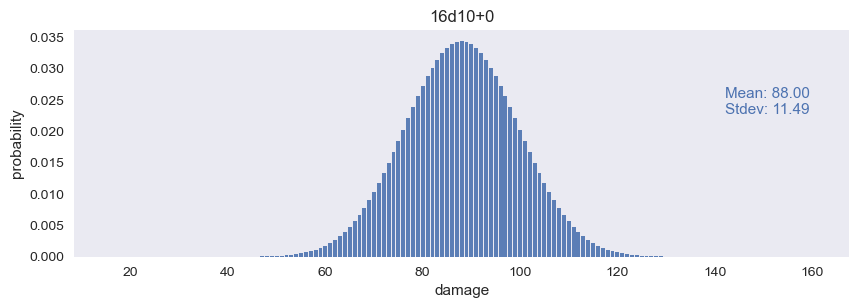

In [12]:
rr()
n=16
d=10
bonus=0
pdist=dice.dice_list(nd_list=[(n,d)], bonus=bonus, debug=True)
dice.make_histogram([pdist], title=f'{n}d{d}+{bonus}')

In [13]:
rr()
dist_1d6 = dice.dice_list([(1,6)])
dist_10d6 = dice.dice_list([(10,6)])
dist_15d6 = dice.dice_list([(15,6)])
dist_20d6 = dice.dice_list([(20,6)])
dist_2d8 = dice.dice_list([(2,8)])
dist_4d8 = dice.dice_list([(4,8)])
dist_1d10 = dice.dice_list([(1,10)])
dist_2d10 = dice.dice_list([(2,10)])
dist_4d10 = dice.dice_list([(4,10)])
dist_6d10 = dice.dice_list([(6,10)])
dist_8d10 = dice.dice_list([(8,10)])

Splitting in chunks of 5 to save processing time...
Splitting in chunks of 6 to save processing time...
Splitting in chunks of 6 to save processing time...
Splitting in chunks of 5 to save processing time...
Splitting in chunks of 5 to save processing time...


### Now go totally insane and string them together with dice.joint_dist()

create tuples       :   1.00   Delta:   0.00
it products         : 140.27   Delta: 139.27
sums & prods        : 1055.54   Delta: 915.27
groupby             : 1314.59   Delta: 259.05


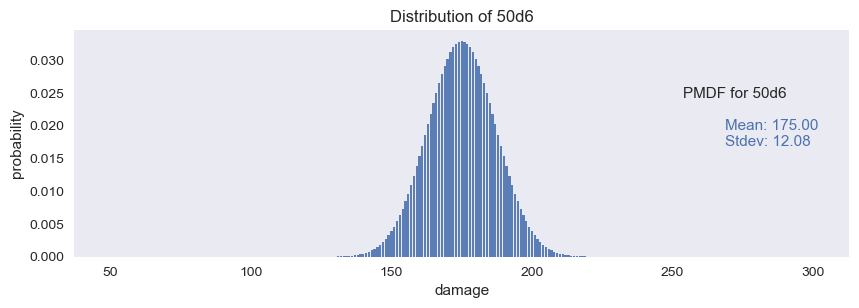

Wall time: 2.08 s


In [14]:
%%time
pdist = dice.joint_dist([dist_20d6,dist_20d6,dist_10d6], debug=True)
dice.make_histogram([pdist], title='Distribution of 50d6', description='PMDF for 50d6')

In [15]:
%%time
rr()
n=20
d=6
bonus = 0
pdist=dice.dice_list([(n,d)], bonus)
df =pd.DataFrame(pdist, columns=['damage', 'probability'])
df

Splitting in chunks of 6 to save processing time...
Wall time: 1.02 s


### Wow, now I finally learned how to use **kwargs - passing dictionaries to functions

In [16]:
kwargs = {'hit_bonus':15, 'AC':20, 'nd_list':[(6,8)], 'bonus':4, 'dice_type':'normal'}

In [17]:
pdist = dice.hitstats(**kwargs)

Splitting in chunks of 5 to save processing time...


Splitting in chunks of 5 to save processing time...


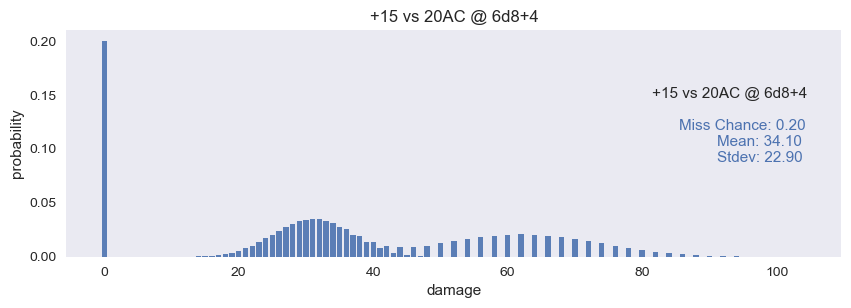

In [18]:
rr()
dice.multiple_attack([kwargs])

### Stringing multiple attacks together with dice.multiple_attack([kwargs])

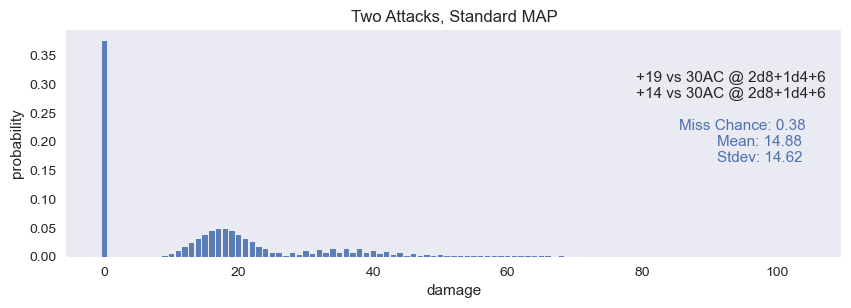

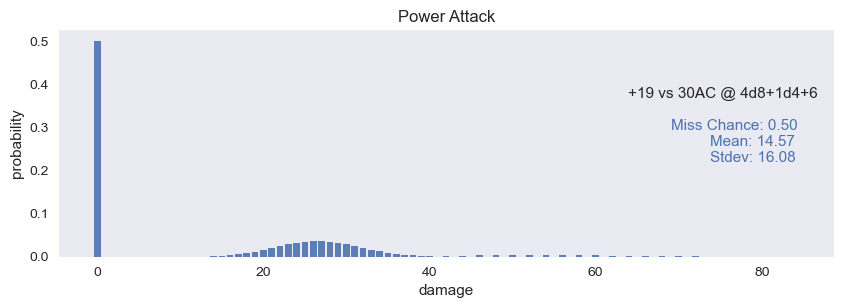

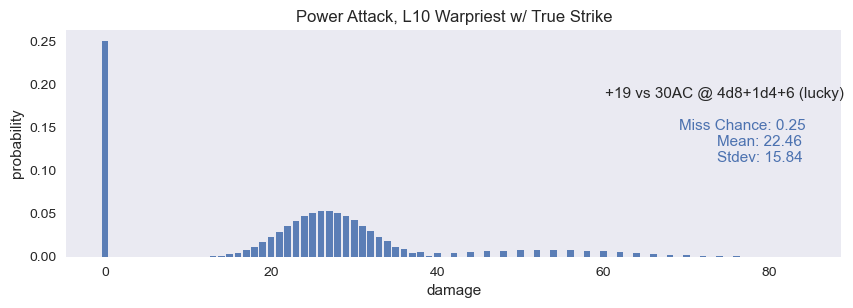

In [19]:
rr()
AC=30
hit_bonus = 19
bonus=6
hit_probability = dice.to_hit(hit_bonus=hit_bonus, AC=AC)[1]
kwargs = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':[(2,8),(1,4)], 'bonus':bonus, 'dice_type':'normal'}
kwargs_map = {'hit_bonus':hit_bonus-5, 'AC':AC, 'nd_list':[(2,8),(1,4)], 'bonus':bonus, 'dice_type':'normal'}
kwargs_exacting = {'hit_bonus':hit_bonus-int(5*hit_probability), 'AC':AC, 'nd_list':[(2,8),(1,4)], 'bonus':bonus, 'dice_type':'normal'}
kwargs_pa = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':[(4,8),(1,4)], 'bonus':bonus, 'dice_type':'normal'}
kwargs_pa_lucky = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':[(4,8),(1,4)], 'bonus':bonus, 'dice_type':'lucky'}
# dice.multiple_attack([kwargs, kwargs], title='Two full attacks (Not possible)')
dice.multiple_attack([kwargs, kwargs_map], title='Two Attacks, Standard MAP')
dice.multiple_attack([kwargs_pa], title='Power Attack')
dice.multiple_attack([kwargs_pa_lucky], title='Power Attack, L10 Warpriest w/ True Strike')
#dice.multiple_attack([kwargs, kwargs_exacting], title='Two Attacks, Exacting Strike')

### Using dice.ac_scan() to get the story on a set of attacks vs all ACs

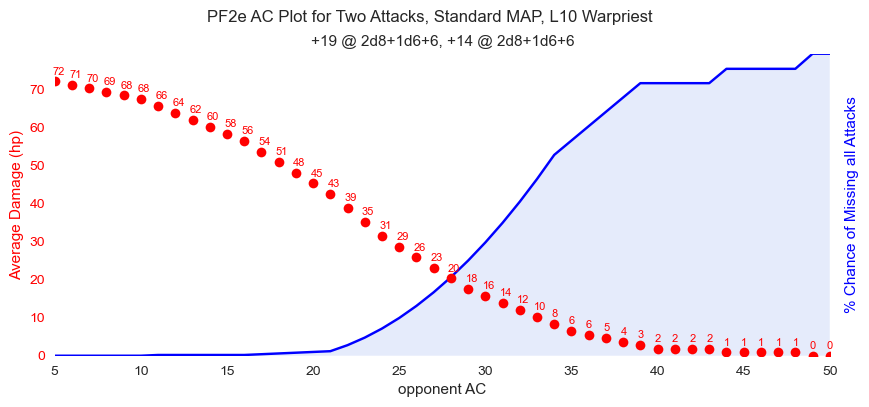

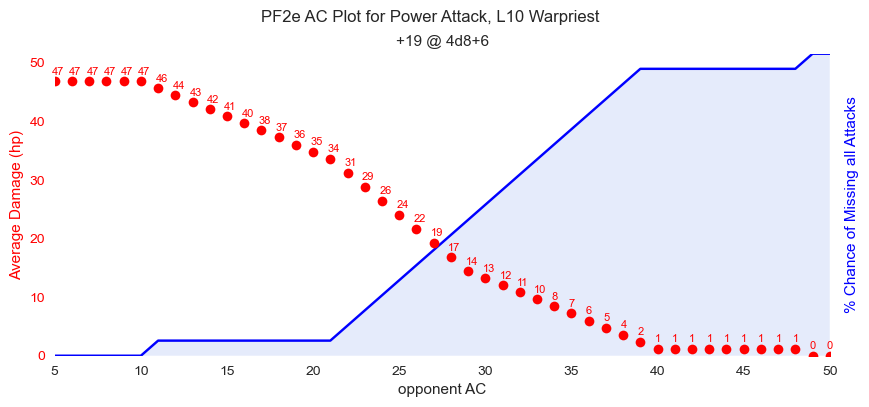

Wall time: 1.59 s


In [36]:
%%time
rr()
hit_bonus = 19
bonus = 6
nd=[(2,8),(1,6)]
ndpa = [(4,8)]
output='plot'
AC=25
speed_boost=True
hit_probability = dice.to_hit(hit_bonus=hit_bonus, AC=AC)[1]

kwargs = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_lucky = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'lucky'}
kwargs_map = {'hit_bonus':hit_bonus-5, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_map2 = {'hit_bonus':hit_bonus-10, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_map2_pa = {'hit_bonus':hit_bonus-10, 'AC':AC, 'nd_list':ndpa, 'bonus':bonus, 'dice_type':'normal'}
kwargs_exacting = {'hit_bonus':hit_bonus-int(5*hit_probability), 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_pa = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':ndpa, 'bonus':bonus, 'dice_type':'normal'}
kwargs_pa_lucky = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':ndpa, 'bonus':bonus, 'dice_type':'lucky'}

dice.ac_scan([kwargs, kwargs_map], title='Two Attacks, Standard MAP, L10 Warpriest', output=output, speed_boost=speed_boost, start_ac=5, end_ac=50)
#desc = f'+{hit_bonus} @ 2d8+1d4+6, {hit_bonus}-?? @ 2d8+1d4+6'
#dice.ac_scan([kwargs, kwargs_exacting], title='Two Attacks, Exacting Strike, L10 Warpriest', description=desc,  output=output, start_ac=5, end_ac=50, exacting=True)
dice.ac_scan([kwargs_pa], title='Power Attack, L10 Warpriest', output=output, speed_boost=speed_boost, start_ac=5,end_ac=50)
#dice.ac_scan([kwargs_pa_lucky], title='Power Attack, L10 Warpriest w/ True Strike', output=output, speed_boost=speed_boost, start_ac=5,end_ac=50)


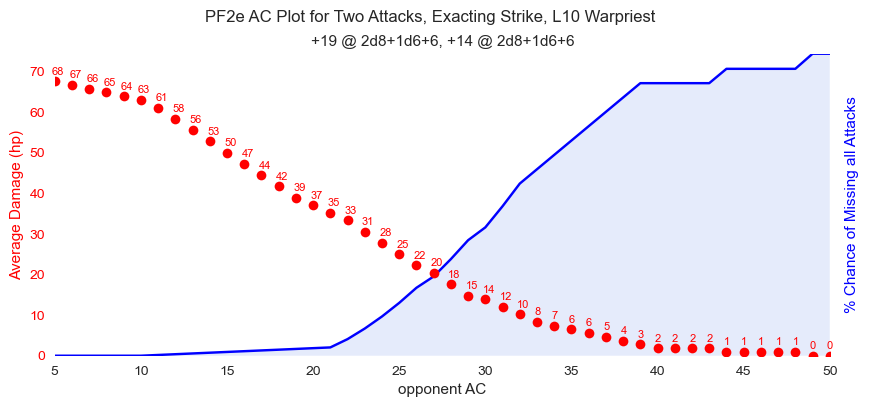

In [21]:
dice.ac_scan([kwargs, kwargs_exacting], title='Two Attacks, Exacting Strike, L10 Warpriest', description=None,  output=output, start_ac=5, end_ac=50, exacting=True)

### Comparing two AC scans with dice.ac_scan_comparison()

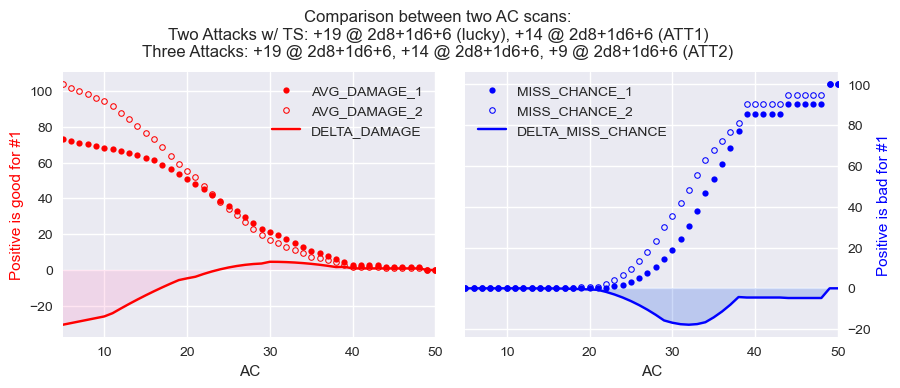

Wall time: 1.32 s


In [22]:
%%time
rr()
k1 = [kwargs_lucky, kwargs_map]
k2 = [kwargs, kwargs_map, kwargs_map2]
dice.ac_scan_comparison(k1, k2, start_ac=5, end_ac=50, description_1='Two Attacks w/ TS', description_2='Three Attacks', speed_boost=True,  output='plot')

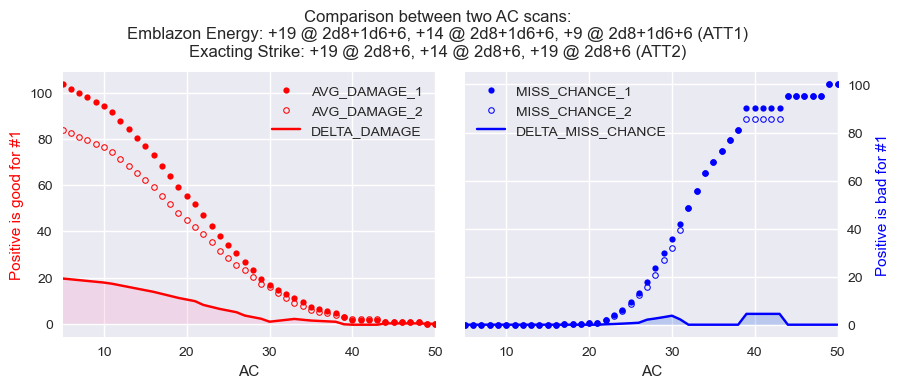

Wall time: 1.45 s


In [23]:
%%time
rr()

hit_bonus = 19
bonus = 6
nd_energy=[(2,8),(1,6)]
nd = [(2,8)]
ndpa = [(4,8)]
output='plot'
AC=25
speed_boost=True

kwargs = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_energy = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':nd_energy, 'bonus':bonus, 'dice_type':'normal'}
kwargs_lucky = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'lucky'}
kwargs_map = {'hit_bonus':hit_bonus-5, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_map_energy = {'hit_bonus':hit_bonus-5, 'AC':AC, 'nd_list':nd_energy, 'bonus':bonus, 'dice_type':'normal'}
kwargs_map2 = {'hit_bonus':hit_bonus-10, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_map2_energy = {'hit_bonus':hit_bonus-10, 'AC':AC, 'nd_list':nd_energy, 'bonus':bonus, 'dice_type':'normal'}
kwargs_map_pa = {'hit_bonus':hit_bonus-5, 'AC':AC, 'nd_list':ndpa, 'bonus':bonus, 'dice_type':'normal'}
kwargs_exacting = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':nd, 'bonus':bonus, 'dice_type':'normal'}
kwargs_pa = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':ndpa, 'bonus':bonus, 'dice_type':'normal'}
kwargs_pa_lucky = {'hit_bonus':hit_bonus, 'AC':AC, 'nd_list':ndpa, 'bonus':bonus, 'dice_type':'lucky'}
k1 = [kwargs_energy, kwargs_map_energy, kwargs_map2_energy]
k2 = [kwargs, kwargs_map, kwargs_exacting]
dice.ac_scan_comparison(k1, k2, start_ac=5, end_ac=50, description_1='Emblazon Energy', description_2='Exacting Strike', speed_boost=True,  output='plot', exacting=(False,True))

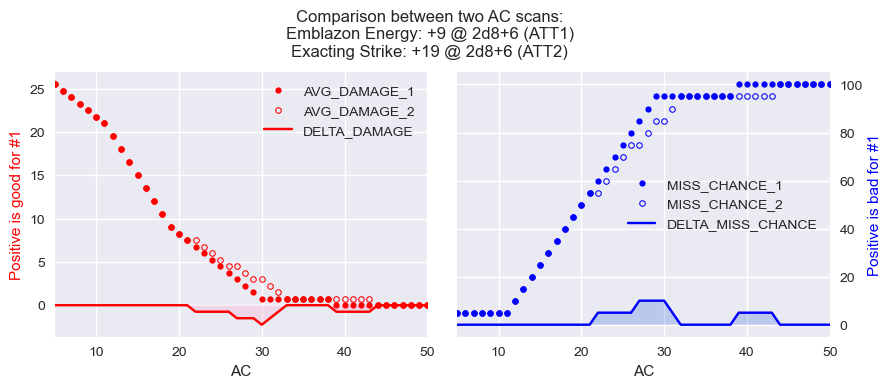

In [24]:
dice.ac_scan_comparison([kwargs_map2], [kwargs_exacting], start_ac=5, end_ac=50, description_1='Emblazon Energy', description_2='Exacting Strike', speed_boost=True,  output='plot', exacting=(False,True))

Notes
1) Attack + PA always better than PA + attack (pretty obvious)
2) TS+Two attacks always better than TS+PA except at very low AC
3) Exacting vs energy: energy is always better

In [25]:
str = dice.make_label(k1)
str

'+19 vs 25AC @ 2d8+1d6+6, +14 vs 25AC @ 2d8+1d6+6, +9 vs 25AC @ 2d8+1d6+6'

In [26]:
import re

In [27]:
re.sub(r'vs \d*AC ', '', str)

'+19 @ 2d8+1d6+6, +14 @ 2d8+1d6+6, +9 @ 2d8+1d6+6'

In [28]:
np.dot(list(range(1,21)),(dice.pmdf(die, dice_type='lucky')[:,1]))

13.825

In [29]:
import random
lucky = []
unlucky = []
normal = []
for i in range(300000):
    d1=random.randint(1,20)
    d2=random.randint(1,20)
    lucky.append(max(d1,d2))
    normal.append(d1)
    unlucky.append(min(d1,d2))
print(f'means are: normal: {np.mean(normal):.2f} lucky: {np.mean(lucky):.2f} unlucky: {np.mean(unlucky):.2f}')

means are: normal: 10.50 lucky: 13.82 unlucky: 7.17


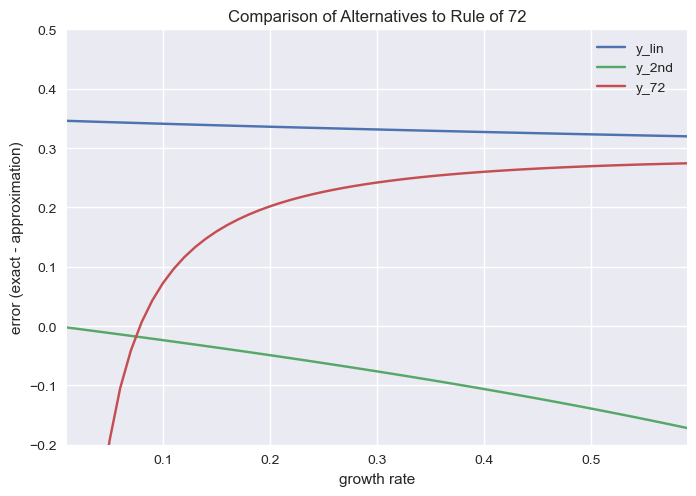

In [30]:
x = np.arange(0.01,0.6,0.01)
y_exact = np.log(2)/(np.log(1+x))
y_72 = y_exact- .72/x
y_lin = y_exact-  (np.log(2)/x + 0)
y_2nd = y_exact- np.log(2)/(x-0.5*x**2)
cols=['x','y_exact','y_lin','y_2nd','y_72']
df = pd.DataFrame(list(zip(x,y_exact,y_lin,y_2nd,y_72)), columns=cols)
ax = df[['x','y_lin','y_2nd','y_72']].plot(x='x', ylim=(-.2,.5), title="Comparison of Alternatives to Rule of 72")
ax.set_ylabel('error (exact - approximation)'); ax.set_xlabel('growth rate')
plt.show()

In [31]:
kwargs = {'nd_list':[(6,8)], 'bonus':4, 'dice_type':'normal'}
kwargs = {'hit_bonus':15, 'AC':20, 'nd_list':[(2,6)], 'bonus':4, 'dice_type':'normal'}
dice.make_label([kwargs])

'+15 vs 20AC @ 2d6+4'

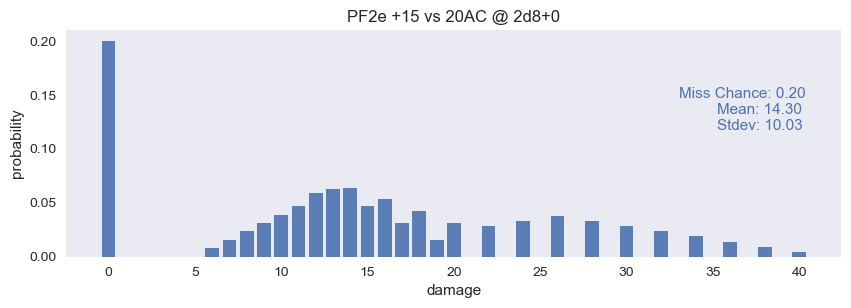

In [32]:
rr()
pdist=dice.hitstats(hit_bonus=15, AC=20, nd_list=[(2,8)], bonus=4, dice_type='normal')
dice.make_histogram([pdist], title='PF2e +15 vs 20AC @ 2d8+0')

Splitting in chunks of 5 to save processing time...


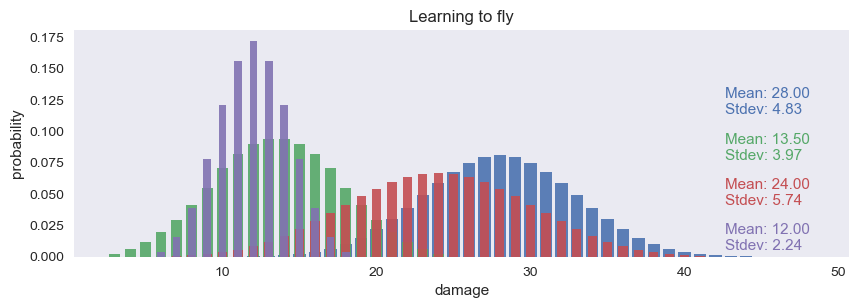

In [33]:
rr()
pdist_1 = dice.dice_list([(8,6)])
pdist_2 = dice.dice_list([(3,8)])
pdist_3 = dice.dice_list([(4,10)],bonus=2)
pdist_4 = dice.dice_list([(4,4)],bonus=2)
dice.make_histogram([pdist_1,pdist_2, pdist_3, pdist_4], title='Learning to fly')


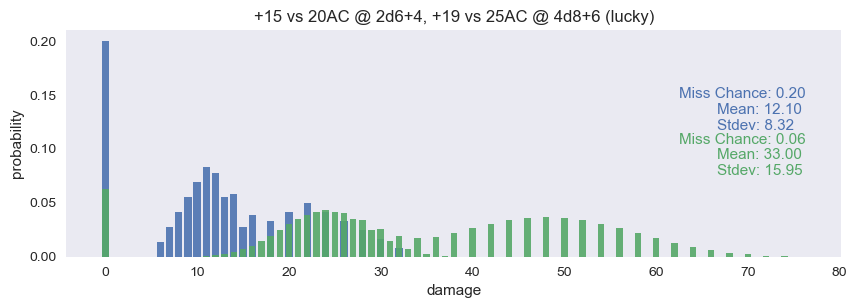

In [34]:
rr()
x = dice.multi_histogram(attack_list=[kwargs,kwargs_pa_lucky])

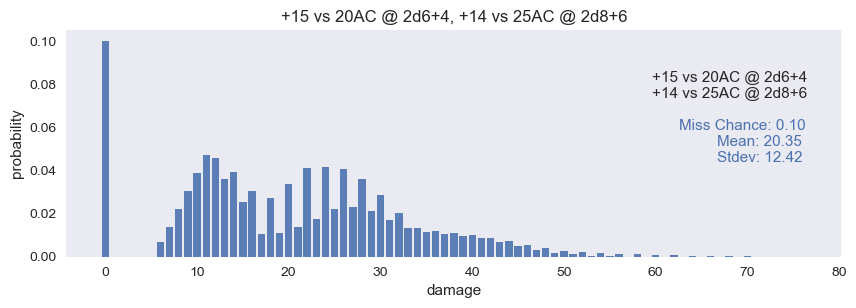

In [35]:
dice.multiple_attack([kwargs, kwargs_map], output='histogram')